### LSTM Model

### Bi-Directional LSTM Keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
df = pd.read_csv('drive/My Drive/Blog post/SVM/Data/IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
print(df.shape)

(50000, 2)


In [0]:
print(df['sentiment'].value_counts())

negative    25000
positive    25000
Name: sentiment, dtype: int64


In [0]:
# select a sample row
df.iloc[49995,:][0]

"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a classic in like 20 yrs. Don't wait for it to be a classic, watch it now and enjoy it. Don't expect a masterpiece, or something thats gripping and soul touching, just allow yourself to get out of your life and get yourself involved in theirs.<br /><br />All in all, this movie is entertaining and i recommend people who haven't seen it see it, because what the critics and box office say doesn't always count, see it for yourself, you never know, you might just enjoy it. I tip my hat to this movie<br /><

## String Preprocessing
- html strips contains <br />
- remove punctuation
- remove stopwords
- stemming

In [0]:
pd.options.display.max_colwidth = 1000
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
#     text = remove_between_square_brackets(text)
    return text

#Apply function on review column
df['review']=df['review'].apply(denoise_text)

# remove punctuation, special characters
df["review"] = df['review'].str.replace('[^\w\s]','')


### remove stopwords

In [0]:
stop = set(stopwords.words('english'))
df['review_without_stopwords'] = df["review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Stemming: 
- Turn the word into the root form 
    - Example: Playing, plays, played --> play
    - Example: am, are, is --> be
    - Example: car, cars, car's --> car
- romve the suffixes and prefixes use of a word
- Stemming with nltk package

In [0]:
#Stemming the text
def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
df['review_after_stemming']=df['review'].apply(stemmer)

### Tokenize
- Tokenize the words

In [0]:
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['review_after_stemming']), axis=1)
df['len_tokenized_sents'] = df.apply(lambda row: len(row['review_after_stemming']), axis=1)

## Transfor label into numeric value

In [0]:
def label(df):
    if df['sentiment']=='positive':
        return 1
    else:
        return 0

df['label_encode'] = df.apply(label, axis=1) 

## doc2vec model
- Skip-gram
  - Skip-gram picks one nearby word, then supplies it as input to try to predict a target word
- CBOW
  - not to take order of words in to consideration
  - It is a model that tries to predict words given the context of a few words before and a few words after the target word. This is distinct from language modeling, since CBOW is not sequential and does not have to be probabilistic.

### Doc2Vec
- DBOW
  - similar to skip-gram
  - a single paragraph-vector for a whole text is used to predict individual target words, regardless of distance and without any averaging
  - ``dbow_words=1`` : add skip-gram training
  - ``dbow_words=0`` : no skip-gram training
  - ``negative=5`` : default setting 5

### Word2Vec
- skip-gram (sg=1) and CBOW (sg=0)
- ``negative=5`` : default setting 5

### hierarchical-softmax vs negative-sampling
- determines how target-word predictions are read from the neural-network

## hierarchical-softmax
- instead of every preictable word having its own output, which nodes should be closer to 1.0 or 0.0 in order to represent a word is matter of the word's encoding, which is calculated so that common words have short encodings (involving just a few nodes), while rare words will have longer encodings (involving more nodes)
- get slower with larger vocabularies (because the average number of nodes involved in each training-example grows)

## negative-sampling
- Sparse approach to only look at N+1 nodes and igonre the rest, look at **N worng words** , nudges the network's internal weights and the input-vectors to make the 'correct' word output node activation a little stronger
- Redice computation time
- ``negative=2``: 2 negative-examples
- negative-sampling does not increase computation time when corpus is large (because it's always N+1 nodes)

In [0]:
train_data

array([list(['As', 'much', 'as', 'I', 'love', 'train', 'I', 'couldnt', 'stomach', 'thi', 'movi', 'the', 'premis', 'that', 'one', 'could', 'steal', 'a', 'locomot', 'and', 'drive', 'from', 'arkansa', 'to', 'chicago', 'without', 'hit', 'anoth', 'train', 'along', 'the', 'way', 'ha', 'to', 'be', 'right', 'up', 'there', 'on', 'the', 'imposs', 'plot', 'line', 'hit', 'board', 'imagin', 'two', 'disgruntl', 'nasa', 'employe', 'steal', 'the', 'crawler', 'that', 'tote', 'the', 'shuttl', 'to', 'and', 'fro', 'and', 'drive', 'it', 'to', 'new', 'york', 'and', 'you', 'get', 'the', 'ideahav', 'said', 'all', 'that', 'it', 'a', 'nice', 'tri', 'wilford', 'brime', 'is', 'at', 'hi', 'quaker', 'oat', 'best', 'and', 'levon', 'helm', 'turn', 'a', 'good', 'perform', 'as', 'hi', 'dimwit', 'but', 'wellmean', 'sidekick', 'bob', 'balaban', 'is', 'suitabl', 'wormi', 'as', 'the', 'corpor', 'guy', 'and', 'the', 'littl', 'guy', 'take', 'on', 'goliath', 'stori', 'get', 'anoth', 'air']),
       list(['thi', 'wa', 'a', 've

In [0]:

X_train, X_test, y_train, y_test = train_test_split(df['tokenized_sents'], df['label_encode'], test_size=0.3, random_state=42)


In [12]:
# turn pandas series into array
train_data = X_train.to_numpy()
test_data = X_test.to_numpy()
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(train_data)]


tagged_test = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(test_data)]

max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=350,
                window=10,
                # The window size is the maximum context location
                # at which the words need to be predicted.
                alpha=alpha, # The initial learning rate
                min_alpha=0.00025,
                # Learning rate will linearly drop to
                # min_alpha as training progresses
                min_count=1,
                dbow_words=0,
                dm =0)

'''
dm defines the training algorithm. If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means 
‘distributed bag of words’ (PV-DBOW). Distributed Memory model preserves the word order in a document 
whereas Distributed Bag of words just uses the bag of words approach, which doesn’t preserve any word order'''


model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [0]:
model= Doc2Vec.load("d2v.model")

# Extract training vectors:
train_doc2vec = np.array([model.docvecs[str(i)] for i in range(len(tagged_data))])

# Extract test vectors:
test_doc2vec = np.array([model.infer_vector([str(i)]) for i in range(len(tagged_test))])


In [0]:
train_doc2vec.shape

(35000, 350)

# Text Processing
- Tokenizer(num_words=2000)
  - no matter how many words are assigned, len(tokenizer.word_index) not be affected

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

maxlen = 800 #caught off point of the lenght of a sentence

tokenizer = Tokenizer(num_words=2000)
#fits the comments on the comments
tokenizer.fit_on_texts(df.review.values)
#changes the tokens into sequence data structures
post_seq= tokenizer.texts_to_sequences(df.review.values)
post_seq_padded= pad_sequences(post_seq, maxlen=maxlen)

y = df['label_encode'].values

X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3, random_state=23)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
X_test.shape

(15000,)

In [17]:
# tokenizer num_words = 450
vocab_size = len(tokenizer.word_index)
vocab_size

222908

In [19]:
# tokenizer num_words = 1000
vocab_size = len(tokenizer.word_index)
vocab_size

222908

## Bi-Directional LSTM Keras

- Embedding(2200, 350 , weights=[train_doc2vec], input_length=maxlen)
  - when placed weights for the embedding layer, the output shape for embedding layer shall be (35000, 350) same with train_doc2vec shape
- Embedding(35000, 350 , weights=[train_doc2vec], input_length=maxlen, trainable=True)
  - set ``trainable=True``, can train weights on the embedding layer
- Embedding(2000, 350, input_length=maxlen)
  - when no weights are assigned into embedding layer, the output shape of embedding layer (2000, #), 2000 shall be matched with tokenizer (num_words)

In [34]:
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_features = 22000 # number of words to be used in the word corpse
maxlen = 800

# # shrink the size of the sequence layer
# post_seq_padded= pad_sequences(post_seq, maxlen=maxlen)

model = Sequential()
model.add(Embedding(35000, 350 , weights=[train_doc2vec], input_length=maxlen, trainable=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


# prints out summary of model
model.summary()

# saves the model weights
# the train/validation/test split is 26500/8750/15000, it's essential to hold out a decent chunck of unseen data
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history = model.fit([X_train], batch_size=32, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 800, 350)          12250000  
_________________________________________________________________
dropout_21 (Dropout)         (None, 800, 350)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               212480    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 12,462,738
Trainable params: 12,462,738
Non-trainable params: 0
_________________________________________________________________
Train on 26250 samples, validate on 8750 samples
Epoch 1/5
26250/26250 [==============================] - 1

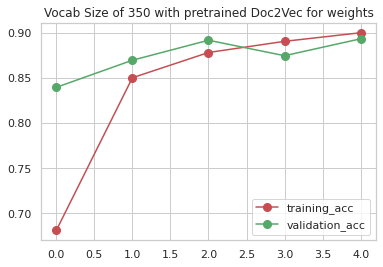

In [35]:
#plot model
sns.set(style="whitegrid")
fig, ax = plt.subplots()
df_result = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
plt.plot(df_result["epochs"], df_result["accuracy"], "o-", ms=8,
            color="r", label='training_acc')
plt.plot(df_result["epochs"], df_result["validation_accuracy"], "o-", ms=8,
            color="g", label='validation_acc')
plt.title('Vocab Size of 350 with pretrained Doc2Vec for weights')
ax.legend()